In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_frame(filename):
    return np.load(filename).astype(np.float32)

(41, 153600)


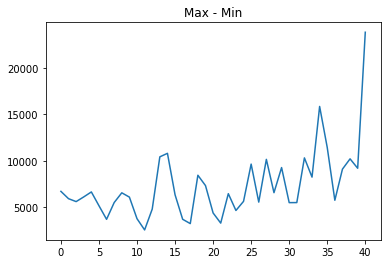

(86, 153600)


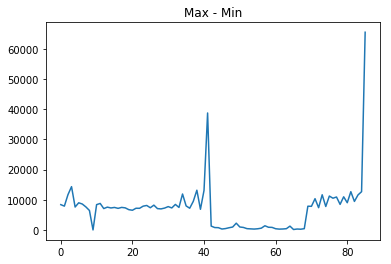

(71, 153600)


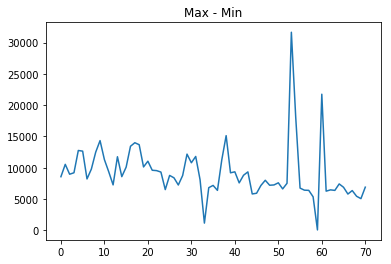

In [3]:
filenames = glob.glob('*npy')
frames = list(map(get_frame, filenames))


for frame in frames:
    print(frame.shape)
    plt.plot(frame.max(axis=1) - frame.min(axis=1))
    plt.title('Max - Min')
    plt.show()

(41, 153600)


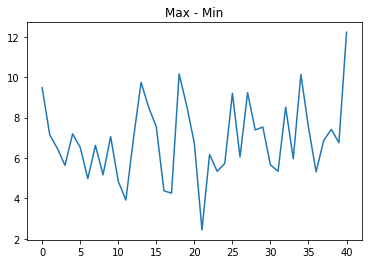

(86, 153600)


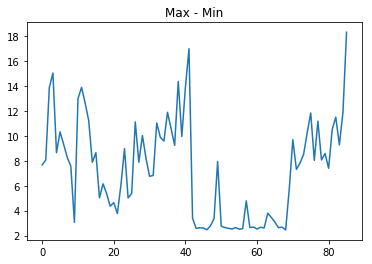

(71, 153600)


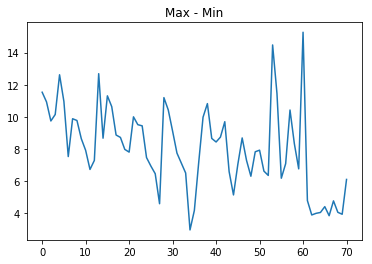

In [4]:
from sklearn.preprocessing import StandardScaler
# or other from: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
# though the QuantileTransformer is sloooow


scaler = StandardScaler()
frames = list(map(scaler.fit_transform, frames))

for frame in frames:
    print(frame.shape)
    plt.plot(frame.max(axis=1) - frame.min(axis=1))
    plt.title('Max - Min')
    plt.show()

In [27]:
from keras.layers import Input, Dense, Dropout, ELU
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2


class UnifyingAutoEncoder:    
    def __init__(self, inp_shapes,
                 unifying_dim=100, num_epochs=10, num_neurons=40,
                 num_layers=2, reg=1e-3):
        self.inp_shapes = inp_shapes
        self.unifying_dim = unifying_dim
        self.num_neurons = num_neurons
        self.num_layers = num_layers
        self.reg = reg
        self.num_epochs = num_epochs

    def fit(self, Xs):        
        self._init_model()
        
        self.model.fit(
            x=Xs,
            y=Xs,
            verbose=2,
            epochs=self.num_epochs,
            class_weight=None,
        )
        return self

    def _init_model(self):
        inputs = [Input((shape, )) for shape in self.inp_shapes]
        
        unifying_strata = [Dense(self.unifying_dim)(inp) for inp in inputs]

        base_network = self._create_base_network()
        ae_strata = [base_network(uni_layer) for uni_layer in unifying_strata]
        
        for stratum, out_shape in zip(ae_strata, self.inp_shapes):
            print(out_shape)
        output_strata = [
            Dense(out_shape)(stratum) 
            for stratum, out_shape in zip(ae_strata, self.inp_shapes)
        ]

        self.model = Model(inputs, output_strata)
        
        self.model.compile(
            optimizer='adam',
            loss='mean_squared_error',
        )
        
    def _create_base_network(self):
        inp = Input(shape=(self.unifying_dim, ))
        x = Dense(self.num_neurons, kernel_regularizer=l2(self.reg))(inp)
        x = ELU()(x)
        for _ in range(self.num_layers-1):
            x = Dense(self.num_neurons, kernel_regularizer=l2(self.reg))(x)
            x = ELU()(x)
        return Model(inputs=inp, outputs=x)

In [28]:
inp_shapes = [frame.shape[0] for frame in frames]
uniae = UnifyingAutoEncoder(inp_shapes=inp_shapes)

In [31]:
uniae.fit([frame.T for frame in frames]);

41
86
71
Epoch 1/10
12s - loss: 0.2814 - dense_45_loss: 0.0286 - dense_46_loss: 0.0702 - dense_47_loss: 0.0967
Epoch 2/10
12s - loss: 0.1116 - dense_45_loss: 0.0020 - dense_46_loss: 0.0282 - dense_47_loss: 0.0570
Epoch 3/10
14s - loss: 0.0953 - dense_45_loss: 0.0014 - dense_46_loss: 0.0258 - dense_47_loss: 0.0538
Epoch 4/10
13s - loss: 0.0912 - dense_45_loss: 0.0013 - dense_46_loss: 0.0256 - dense_47_loss: 0.0537
Epoch 5/10
13s - loss: 0.0892 - dense_45_loss: 0.0013 - dense_46_loss: 0.0256 - dense_47_loss: 0.0536
Epoch 6/10
14s - loss: 0.0881 - dense_45_loss: 0.0014 - dense_46_loss: 0.0256 - dense_47_loss: 0.0536
Epoch 7/10
14s - loss: 0.0873 - dense_45_loss: 0.0014 - dense_46_loss: 0.0256 - dense_47_loss: 0.0536
Epoch 8/10
13s - loss: 0.0868 - dense_45_loss: 0.0014 - dense_46_loss: 0.0257 - dense_47_loss: 0.0536
Epoch 9/10
13s - loss: 0.0864 - dense_45_loss: 0.0014 - dense_46_loss: 0.0257 - dense_47_loss: 0.0536
Epoch 10/10
14s - loss: 0.0860 - dense_45_loss: 0.0014 - dense_46_loss: 0

In [51]:
one_row = [frame.T[None, 0, :] for frame in frames]
one_row_imitation = uniae.model.predict(one_row)

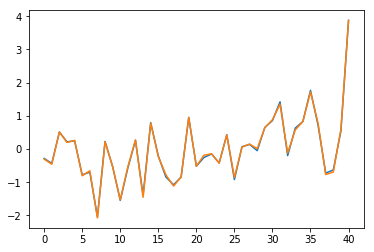

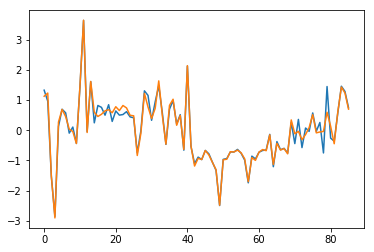

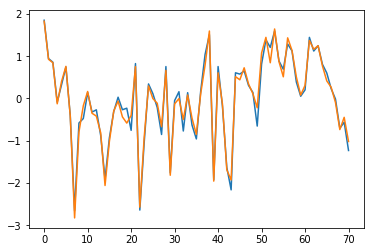

In [78]:
for input_id in range(len(one_row)):
    plt.plot(one_row[input_id].T)
    plt.plot(one_row_imitation[input_id].T)
    plt.show()